# Importing libraries

In [1]:
# Load all required Libraries
import os, re, string, warnings, sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers, torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset


from pymilvus import MilvusClient, FieldSchema, CollectionSchema, DataType

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
)

import tqdm as tqdm
from sentence_transformers import SentenceTransformer
import nltk

sys.path.append(str(Path.cwd().parent / "src"))

from setup import Setup
from evaluation import Evaluation

evaluation = Evaluation()
# call the one method you need
setup = Setup()
setup.download_nltk_data()


/opt/anaconda3/envs/rag2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading and Cleaning data

In [2]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")
passages.reset_index(inplace=True)
passages.rename(columns={"index": "id"}, inplace=True)
print(passages.shape)
passages["processed_passage_tokens"] = passages["passage"].apply(setup.preprocess_text)
passages["passage_clean"] = passages["processed_passage_tokens"].apply(lambda toks: " ".join(toks))
passages.head()


(3200, 2)


,id,passage,processed_passage_tokens,passage_clean
0,0,"Uruguay (official full name in ; pron. , Eas...","[uruguay, official, full, name, pron, eastern,...",uruguay official full name pron eastern republ...
1,1,"It is bordered by Brazil to the north, by Arge...","[border, brazil, north, argentina, across, ban...",border brazil north argentina across bank urug...
2,2,Montevideo was founded by the Spanish in the e...,"[montevideo, found, spanish, early, 18th, cent...",montevideo found spanish early 18th century mi...
3,3,The economy is largely based in agriculture (m...,"[economy, largely, base, agriculture, make, 10...",economy largely base agriculture make 10 gdp s...
4,4,"According to Transparency International, Urugu...","[accord, transparency, international, uruguay,...",accord transparency international uruguay seco...


# Creating Embedding

In [3]:
embedder = setup.build_embedder("all-MiniLM-L6-v2")
passages["embedding"] = (
    passages["passage_clean"]
    .fillna("")
    .astype(str)
    .apply(lambda x: embedder.encode(x, normalize_embeddings=True).astype("float32"))
)

passages.head()

,id,passage,processed_passage_tokens,passage_clean,embedding
0,0,"Uruguay (official full name in ; pron. , Eas...","[uruguay, official, full, name, pron, eastern,...",uruguay official full name pron eastern republ...,"[0.029654771, -0.06880856, -0.057491858, 0.004..."
1,1,"It is bordered by Brazil to the north, by Arge...","[border, brazil, north, argentina, across, ban...",border brazil north argentina across bank urug...,"[0.07190235, -0.04019017, -0.03857681, -0.0580..."
2,2,Montevideo was founded by the Spanish in the e...,"[montevideo, found, spanish, early, 18th, cent...",montevideo found spanish early 18th century mi...,"[-0.024355173, -0.068288386, -0.039410222, -0...."
3,3,The economy is largely based in agriculture (m...,"[economy, largely, base, agriculture, make, 10...",economy largely base agriculture make 10 gdp s...,"[0.019785434, -0.076093115, 0.025713824, 0.023..."
4,4,"According to Transparency International, Urugu...","[accord, transparency, international, uruguay,...",accord transparency international uruguay seco...,"[0.027133217, -0.08261366, -0.09474878, -0.005..."


# Setting up Milvus Client

In [4]:
# init milvus like your notebook
client = setup.init_milvus(
    db_path="rag_wikipedia_mini_3.db",
    collection_name="rag_mini",
    dim=384,
    max_length=8000,
)

# make records and insert (same structure as your cell)
rag_data = passages[["id", "passage", "embedding"]].to_dict(orient="records")
res = client.insert(collection_name="rag_mini", data=rag_data)
print(res)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'insert_count': 3200, 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,

In [5]:
print("Entity count:", client.get_collection_stats("rag_mini")["row_count"])
print("Collection schema:", client.describe_collection("rag_mini"))

Entity count: 6400
Collection schema: {'collection_name': 'rag_mini', 'auto_id': False, 'num_shards': 0, 'description': '', 'fields': [{'field_id': 100, 'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'params': {}, 'is_primary': True}, {'field_id': 101, 'name': 'passage', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 8000}}, {'field_id': 102, 'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}], 'functions': [], 'aliases': [], 'collection_id': 0, 'consistency_level': 0, 'properties': {}, 'num_partitions': 0, 'enable_dynamic_field': False}


# Fetch Results

In [6]:
queries = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
queries.reset_index(inplace=True)
queries.rename(columns={"index": "id"}, inplace=True)
queries.head()

,id,question,answer
0,0,Was Abraham Lincoln the sixteenth President of...,yes
1,2,Did Lincoln sign the National Banking Act of 1...,yes
2,4,Did his mother die of pneumonia?,no
3,6,How many long was Lincoln's formal education?,18 months
4,8,When did Lincoln begin his political career?,1832


In [7]:
setup.create_milvus_index(client, "rag_mini")

In [8]:
query = queries['question'][0]
clean_query = setup.preprocess_text(query)
clean_query = " ".join(clean_query)
print(clean_query)                 # Your single query

query_embedding = embedder.encode(query, normalize_embeddings=True).astype("float32")   

print(query_embedding.shape)

abraham lincoln sixteenth president united state
(384,)


In [9]:
output_ = client.search(
    collection_name="rag_mini",
    data=[query_embedding],
    anns_field= "embedding",
    search_params={"metric_type": "L2", "params": {"nprobe": 10}},
    output_fields=["id", "passage"],
    limit=10
)

print(output_)

data: [[{'id': 288, 'distance': 0.5809625387191772, 'entity': {'id': 288, 'passage': 'Young Abraham Lincoln'}}, {'id': 698, 'distance': 0.8376563787460327, 'entity': {'id': 698, 'passage': 'Sixteen months before his death, his son, John Quincy Adams, became the sixth President of the United States (1825 1829), the only son of a former President to hold the office until George W. Bush in 2001.'}}, {'id': 319, 'distance': 0.8432263135910034, 'entity': {'id': 319, 'passage': 'On November 6, 1860, Lincoln was elected as the 16th President of the United States, beating Democrat Stephen A. Douglas, John C. Breckinridge of the Southern Democrats, and John Bell of the new Constitutional Union Party. He was the first Republican president, winning entirely on the strength of his support in the North: he was not even on the ballot in nine states in the South, and won only 2 of 996 counties in the other Southern states. Lincoln gained 1,865,908 votes (39.9% of the total), for 180 electoral votes; 

In [10]:
context = output_[0][0].entity.get("passage")
print(context)

Young Abraham Lincoln


In [11]:
queries_cot = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
queries_cot.reset_index(inplace=True)
queries_cot.rename(columns={"index": "id"}, inplace=True)
queries_cot['answer_generated'] = ''
queries_cot['context'] = list([] for _ in range(len(queries_cot)))

# Load model once (outside the loop for efficiency)
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer, model = setup.build_llm("google/flan-t5-small")

# Process each question
for idx in tqdm.tqdm(range(len(queries_cot)), desc="Processing queries"):
    query = queries_cot['question'].iloc[idx]
    clean_query = setup.preprocess_text(query)
    clean_query = " ".join(clean_query)
    
    # Get query embedding
    query_embedding = embedder.encode(clean_query, normalize_embeddings=True).astype("float32")   
    
    # Search the database
    output_ = client.search(
        collection_name="rag_mini",
        data=[query_embedding],
        anns_field="embedding",
        search_params={"metric_type": "L2", "params": {"nprobe": 10}},
        output_fields=["id", "passage"],
        limit=5
    )
    
    # Extract context from search results
    context = ""
    if output_ and len(output_[0]) > 0:
        # Get context from the top result
        n = min(3, len(output_[0]))
        for i in range(n):
            c = output_[0][i].entity.get("passage", "")
            context += " " + c
        queries_cot.iloc[idx, queries_cot.columns.get_loc('context')].append(context)    
    # Create prompt
    system_prompt = "You are solving a question using provided context only. Think through the problem internally and do NOT reveal your intermediate reasoning. Return only the final answer and a brief, evidence-based justification."
    prompt = f"{system_prompt} \n Context: {context} \n Question: {query}"
    
    # Generate answer
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_new_tokens=50)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Save answer to dataframe
    queries_cot.iloc[idx, queries_cot.columns.get_loc('answer_generated')] = answer.lower() 

# Save the updated dataframe


scores_cot = Evaluation.score(queries_cot, id_col="id", pred_col="answer_generated", ref_col="answer")
print(scores_cot)

Processing queries: 100%|██████████| 918/918 [03:40<00:00,  4.16it/s]


{'exact_match': 25.70806100217865, 'f1': 33.83608044708323}


# Getting answers using Persona Prompting

In [12]:
queries_pp = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
queries_pp.reset_index(inplace=True)
queries_pp.rename(columns={"index": "id"}, inplace=True)
queries_pp['answer_generated'] = ''
queries_pp['context'] = list([] for _ in range(len(queries)))

# Load model once (outside the loop for efficiency)
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer, model = setup.build_llm("google/flan-t5-small")

# Process each question
for idx in tqdm.tqdm(range(len(queries_pp)), desc="Processing queries"):
    query = queries_pp['question'].iloc[idx]
    clean_query = setup.preprocess_text(query)
    clean_query = " ".join(clean_query)
    
    # Get query embedding
    query_embedding = embedder.encode(clean_query, normalize_embeddings=True).astype("float32")   
    
    # Search the database
    output_ = client.search(
        collection_name="rag_mini",
        data=[query_embedding],
        anns_field="embedding",
        search_params={"metric_type": "L2", "params": {"nprobe": 10}},
        output_fields=["id", "passage"],
        limit=5
    )
    
    # Extract context from search results
    context = ""
    if output_ and len(output_[0]) > 0:
       
        # Get context from the top result
        n = min(3, len(output_[0]))
        for i in range(n):
            c = output_[0][i].entity.get("passage", "")
            context += " " + c
        queries_pp.iloc[idx, queries_pp.columns.get_loc('context')].append(context)    
    # Create prompt
    system_prompt = "You are “The Meticulous Research Librarian”: cautious, concise, and allergic to speculation. Your style: 1–2 sentence answers, strictly grounded in the given context.  If the context is insufficient, say “I don't know."
    prompt = f"{system_prompt} \n Context: {context} \n Question: {query}"
    
    # Generate answer
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_new_tokens=50)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Save answer to dataframe
    queries_pp.iloc[idx, queries_pp.columns.get_loc('answer_generated')] = answer.lower() 

# Save the updated dataframe


scores_pp = Evaluation.score(queries_pp, id_col="id", pred_col="answer_generated", ref_col="answer")
print(scores_pp)

Processing queries: 100%|██████████| 918/918 [02:26<00:00,  6.25it/s]


{'exact_match': 36.81917211328976, 'f1': 44.167656385998214}


# Getting answers using Instruction Prompting

In [13]:
queries_ip = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
queries_ip.reset_index(inplace=True)
queries_ip.rename(columns={"index": "id"}, inplace=True)
queries_ip['answer_generated'] = ''
queries_ip['context'] = list([] for _ in range(len(queries_ip)))

# Load model once (outside the loop for efficiency)
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer, model = setup.build_llm("google/flan-t5-small")

# Process each question
for idx in tqdm.tqdm(range(len(queries_ip)), desc="Processing queries"):
    query = queries_ip['question'].iloc[idx]
    clean_query = setup.preprocess_text(query)
    clean_query = " ".join(clean_query)
    
    # Get query embedding
    query_embedding = embedder.encode(clean_query, normalize_embeddings=True).astype("float32")   
    
    # Search the database
    output_ = client.search(
        collection_name="rag_mini",
        data=[query_embedding],
        anns_field="embedding",
        search_params={"metric_type": "L2", "params": {"nprobe": 10}},
        output_fields=["id", "passage"],
        limit=5
    )
    
    # Extract context from search results
    context = ""
    if output_ and len(output_[0]) > 0:
        # Get context from the top result
        n = min(3, len(output_[0]))
        for i in range(n):
            c = output_[0][i].entity.get("passage", "")
            context += " " + c
        queries_ip.iloc[idx, queries_ip.columns.get_loc('context')].append(context)    
    # Create prompt
    system_prompt = "Follow these rules: 1) Use ONLY the provided context to answer the question. 2) If the answer is not in the context, respond exactly with \"I don't know\". 3) Keep the answer <= 35 words. 4) Include one short evidence quote or passage ID from the context."
    prompt = f"{system_prompt} \n Context: {context} \n Question: {query}"
    
    # Generate answer
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_new_tokens=50)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Save answer to dataframe
    queries_ip.iloc[idx, queries_ip.columns.get_loc('answer_generated')] = answer.lower() 

# Save the updated dataframe


scores_ip = Evaluation.score(queries_ip, id_col="id", pred_col="answer_generated", ref_col="answer")
print(scores_ip)

Processing queries: 100%|██████████| 918/918 [02:30<00:00,  6.12it/s]


{'exact_match': 33.98692810457516, 'f1': 41.00404513320802}


,exact_match,f1
COT,25.71,33.84
PP,36.82,44.17
IP,33.99,41.00


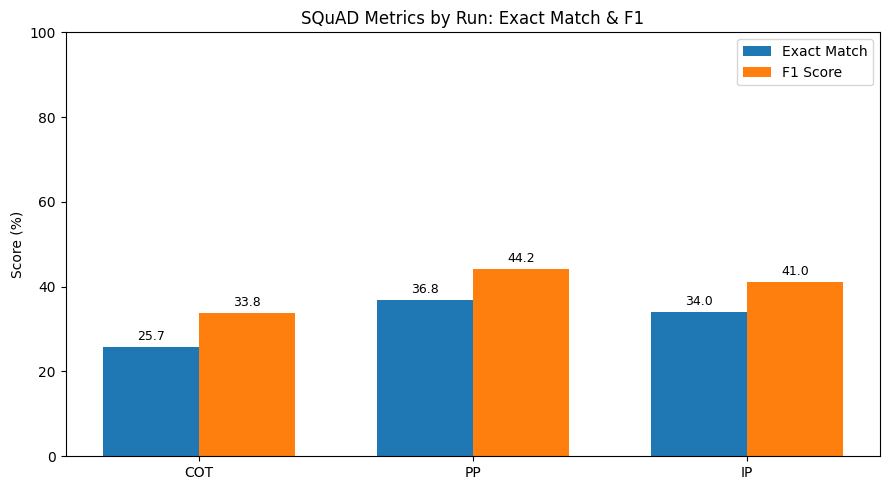

In [14]:
scores_list = [
    scores_cot,
    scores_pp,
    scores_ip
]
labels = ["COT", "PP", "IP"]
df = pd.DataFrame(scores_list, index=labels)[["exact_match", "f1"]]
df = df.round(2)
display(df)

x = np.arange(len(df))
width = 0.35

fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x - width/2, df["exact_match"].values, width, label="Exact Match")
ax.bar(x + width/2, df["f1"].values,       width, label="F1 Score")

ax.set_title("SQuAD Metrics by Run: Exact Match & F1")
ax.set_ylabel("Score (%)")
ax.set_xticks(x)
ax.set_xticklabels(df.index)
ax.set_ylim(0, 100)
ax.legend()

# optional value labels
for i, v in enumerate(df["exact_match"].values):
    ax.text(i - width/2, v + 1, f"{v:.1f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(df["f1"].values):
    ax.text(i + width/2, v + 1, f"{v:.1f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [15]:
subset = queries_cot.sample(n=50, random_state=42)

scores = Evaluation.ragas_scores_df(subset)  # uses columns: question, answer_generated, context, answer
print(scores)['+}']

Evaluating:  46%|████▌     | 91/200 [00:59<01:04,  1.69it/s]Exception raised in Job[97]: IndexError(list index out of range)
Exception raised in Job[93]: IndexError(list index out of range)
Evaluating:  50%|█████     | 100/200 [01:06<01:02,  1.60it/s]Exception raised in Job[113]: IndexError(list index out of range)
Exception raised in Job[105]: IndexError(list index out of range)
Evaluating:  69%|██████▉   | 138/200 [01:27<00:28,  2.16it/s]Exception raised in Job[141]: IndexError(list index out of range)
Exception raised in Job[145]: IndexError(list index out of range)
Exception raised in Job[149]: IndexError(list index out of range)
Evaluating:  78%|███████▊  | 156/200 [01:37<00:23,  1.89it/s]Exception raised in Job[161]: IndexError(list index out of range)
Exception raised in Job[165]: IndexError(list index out of range)
Evaluating:  87%|████████▋ | 174/200 [01:46<00:13,  1.92it/s]Exception raised in Job[181]: IndexError(list index out of range)
Exception raised in Job[185]: IndexErr

{'faithfulness': 0.7483, 'answer_relevancy': 0.4765, 'context_precision': 0.7600, 'context_recall': 0.6000}


In [16]:
subset = queries_pp.sample(n=50, random_state=42)

scores = Evaluation.ragas_scores_df(subset)  # uses columns: question, answer_generated, context, answer
print(scores)

Evaluating:   1%|          | 2/200 [00:01<01:41,  1.94it/s]Exception raised in Job[5]: IndexError(list index out of range)
Exception raised in Job[1]: IndexError(list index out of range)
Evaluating:   8%|▊         | 16/200 [00:11<02:05,  1.46it/s]Exception raised in Job[25]: IndexError(list index out of range)
Exception raised in Job[29]: IndexError(list index out of range)
Evaluating:  49%|████▉     | 98/200 [01:00<00:55,  1.83it/s]Exception raised in Job[101]: IndexError(list index out of range)
Exception raised in Job[109]: IndexError(list index out of range)
Evaluating:  70%|███████   | 141/200 [01:24<00:34,  1.72it/s]Exception raised in Job[145]: IndexError(list index out of range)
Exception raised in Job[153]: IndexError(list index out of range)
Evaluating: 100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


{'faithfulness': 0.6800, 'answer_relevancy': 0.3738, 'context_precision': 0.7600, 'context_recall': 0.6000}


In [17]:
subset = queries_ip.sample(n=50, random_state=42)

scores = Evaluation.ragas_scores_df(subset)  # uses columns: question, answer_generated, context, answer
print(scores)

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]Exception raised in Job[9]: IndexError(list index out of range)
Exception raised in Job[1]: IndexError(list index out of range)
Exception raised in Job[13]: IndexError(list index out of range)
Evaluating:   8%|▊         | 15/200 [00:07<01:20,  2.30it/s]Exception raised in Job[17]: IndexError(list index out of range)
Exception raised in Job[21]: IndexError(list index out of range)
Evaluating:  18%|█▊        | 36/200 [00:18<01:09,  2.37it/s]Exception raised in Job[49]: IndexError(list index out of range)
Exception raised in Job[41]: IndexError(list index out of range)
Exception raised in Job[45]: IndexError(list index out of range)
Evaluating:  31%|███       | 62/200 [00:31<01:13,  1.87it/s]Exception raised in Job[65]: IndexError(list index out of range)
Exception raised in Job[69]: IndexError(list index out of range)
Evaluating:  38%|███▊      | 77/200 [00:39<00:59,  2.07it/s]Exception raised in Job[81]: IndexError(list index out of ran

{'faithfulness': 0.6800, 'answer_relevancy': 0.3977, 'context_precision': 0.7600, 'context_recall': 0.6000}


In [20]:
df.to_csv(str(Path.cwd().parent / "result")+"/top3_results.csv")

In [22]:
raga_scores = [{'faithfulness': 0.7483, 'answer_relevancy': 0.4765, 'context_precision': 0.7600, 'context_recall': 0.6000}, 
               {'faithfulness': 0.6800, 'answer_relevancy': 0.3738, 'context_precision': 0.7600, 'context_recall': 0.6000},
               {'faithfulness': 0.6800, 'answer_relevancy': 0.3977, 'context_precision': 0.7600, 'context_recall': 0.6000}]
raga_df = pd.DataFrame(raga_scores, index=labels)[['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']]
raga_df.to_csv(str(Path.cwd().parent / "result")+"/top3_raga_scores.csv")